# [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)

파인 튜닝 튜토리얼 따라해보자.

## 1. Setup

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU :', torch.cuda.get_device_name(0))
else:
    device = torch.device('cput')

GPU : GeForce GTX 1660 Ti


## 2. CoLA 데이터셋 로딩

[The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) 데이터셋을 쓴다. 이 데이터는 문법적으로 옳은지 틀린지를 라벨링했다.

### 2.1. 다운로드 & 압축해제

In [2]:
!pip install wget

In [3]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [4]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

### 2.2. 파싱

데이터에 토큰화된 버전과 raw 데이터가 있는데, BERT 쓰려면 미리 정해진 대로 토크나이즈 해야하므로 raw 데이터를 써야만 한다. 

In [5]:
import pandas as pd

df = pd.read_csv('./cola_public/raw/in_domain_train.tsv', delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
print(f'훈련 데이터 수 : {df.shape[0]}')

# 10개 샘플 출력
df.sample(10)

훈련 데이터 수 : 8551


,sentence_source,label,label_notes,sentence
7157,sks13,1,NaN,This girl in the red coat or you will put a pi...
5515,b_73,1,NaN,Most helpful advice is unwanted.
8176,ad03,1,NaN,The amoeba coughed and then it fainted.
6270,c_13,1,NaN,Susan begged Bill to let her sing in the concert.
5856,c_13,1,NaN,That Harry loves dancing is evidenced by his s...
1943,r-67,0,*,I didn't eat the ice cream and any cake.
8057,ad03,0,*,Jason killed.
1614,r-67,1,NaN,Romeo conceded that he and Juliet were going s...
7011,sgww85,1,NaN,Ronnie was talking to Lou.
5320,b_82,1,NaN,Would John hate that!


문법적으로 틀렸다고 판단된 문장을 샘플링해보자.

In [6]:
df.loc[df.label==0].sample(5)[['sentence', 'label']]

,sentence,label
747,We proclaimed sincerely John to be a hero.,0
7210,What Mary donated was a lot of money to NPR.,0
8479,She tried to do go.,0
7897,Moya played football with her,0
2749,Carmen obtained a spare part to Mary.,0


문장과 라벨만 분리하자.

In [7]:
sentences = df.sentence.values
labels = df.label.values

## 3. 토큰화 & 입력 포맷 수정

### 3.1. BERT 토크나이저

In [8]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/home/inhwan/Python/Pytorch_ev/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/inhwan/Python/Pytorch_ev/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/inhwan/Python/Pytorch_ev/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/inhwan/Python/Pytorch_ev/lib/python3.7/site-packages

한 문장에 적용해보자.

In [9]:
print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


데이터를 모두 처리하기 위해서는 `tokenize.encode`를 쓴다.

### 3.2. 자료 포매팅

BERT 모델이 요구하는 대로 다음과 같이 입력 포맷을 맞춘다.

1. 문장의 시작과 끝에 스페셜 토큰을 추가한다.
1. 패딩과 자르기를 통해 문장의 길이를 일정하게 맞춘다.
1. 실제 토큰과 패딩을 'attention mask'를 통해 분리한다. 

스페셜 토큰의 종류는 다음과 같다.

* [SEP] : 문장의 끝에 추가한다.
* [CLS] : 분류 모델을 위해 모든 문장의 시작에 추가해야 한다. 이 토큰의 최종 출력값을 통해 실제 분류를 한다.

![CLS](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

또한 [PAD] 토큰을 적절히 추가해서 길이를 맞춰야 한다.

![PAD](http://www.mccormickml.com/assets/BERT/padding_and_mask.png)

최대 문장의 길이는 훈련에 매우 큰 영향을 미친다.

### 3.3. 데이터셋 토크나이즈

일단 최대 길이를 정하기 위해 실제 문장의 최대 길이를 구해보자.

In [10]:
max_len = 0

for sent in sentences:
    # 토큰화하고 [CLS], [SEP] 토큰 추가
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
    
print('문장 최대 길이 : ', max_len)

문장 최대 길이 :  47


테스트셋에 혹시 긴 문장이 있을지도 모르니 최대 길이는 64로 하자. 

`tokenizer.encode_plus` 함수는 다음과 같은 일을 해준다.

1. 토큰화
1. [CLS], [SEP] 토큰 추가
1. 토큰을 ID로 변경
1. 모든 문장을 동일한 길이로 변환
1. 어텐션 마스크 생성

`tokenizer.encode`는 앞의 네 개를 해주지만 마지막 하나는 `encode_plus`만 해줌

In [11]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens = True,
        max_length = 64,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


In [12]:
# 리스트를 텐서로 변환하자.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

0번째를 확인해보자.

In [13]:
print('Original: ', sentences[0])
print('Token IDs: ', input_ids[0])
print('Attention mask: ', attention_masks[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs:  tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Attention mask:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### 3.4. 훈련&검증셋 분리

데이터의 90%를 훈련셋, 10%를 검증셋으로 분리하자.

In [14]:
input_ids.size(), attention_masks.size(), labels.size()

(torch.Size([8551, 64]), torch.Size([8551, 64]), torch.Size([8551]))

In [15]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [16]:
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


이터레이터를 만들자.

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset), # 랜덤하게 배치 생성
        batch_size = batch_size
    )

validation_dataloader = DataLoader(
        val_dataset,
        sampler = SequentialSampler(val_dataset), # 순차적으로 처리
        batch_size = batch_size
    )

## 4. 훈련

### 4.1. BertForSequenceClassification

현재 Huggingface의 transformers에서 제공하는 BERT의 fine tuning 모델은 다음과 같다.

* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* BertForSequenceClassification 
* BertForTokenClassification
* BertForQuestionAnswering

우리는 `BertForSequenceClassification`를 쓸건데, 이건 BERT에 linear layer를 얹어서 분류로 쓰는 모델이다. 우리는 `bert-base-uncased`를 쓸 예정인데, 이건 소문자만 처리하고 상대적으로 작은('based' vs 'large') 모델이다.

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2, # 이진분류
    output_attentions = False, # 어텐션 웨이트 반환 여부
    output_hidden_states = False, # 모든 히든 스테이트 반환 여부
    )
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

모델의 파라미터를 출력해보자.

In [19]:
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### 4.2. 옵티마이저 & 러닝레이트 스케줄러

하이퍼파라미터는 논문대로 하자.

* Batch size: 32
* Learning rate (Adam): 2e-5
* Number of epochs: 4

In [20]:
optimizer = AdamW(model.parameters(),
                 lr = 2e-5,
                 eps = 1e-8)

In [21]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)

### 4.3. 훈련 루프

헬퍼 펑션을 만들자.

In [22]:
import numpy as np

# accuracy 측정 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    걸린 시간 측정
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

훈련을 시작하자.

In [24]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [25]:
training_stats = []
total_t0 = time.time()

for epoch_i in range(epochs):
    # training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        
        # 업데이트는 40배치마다
        if step % 40 == 0 and not step == 0 :
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()
        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        total_train_loss += loss.item()
        loss.backward()
        
        # 그래디언트 클래핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
    
    # loss 계산
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    # 걸린 시간 계산
    training_time = format_time(time.time() - t0)
    

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))    


    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))    
    

    # 에폭마다 훈련 상태 기록
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))    


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    481.    Elapsed: 0:00:08.
  Batch    80  of    481.    Elapsed: 0:00:15.
  Batch   120  of    481.    Elapsed: 0:00:23.
  Batch   160  of    481.    Elapsed: 0:00:31.
  Batch   200  of    481.    Elapsed: 0:00:39.
  Batch   240  of    481.    Elapsed: 0:00:46.
  Batch   280  of    481.    Elapsed: 0:00:54.
  Batch   320  of    481.    Elapsed: 0:01:02.
  Batch   360  of    481.    Elapsed: 0:01:10.
  Batch   400  of    481.    Elapsed: 0:01:17.
  Batch   440  of    481.    Elapsed: 0:01:25.
  Batch   480  of    481.    Elapsed: 0:01:33.

  Average training loss: 0.48
  Training epoch took: 0:01:33

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.49
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    481.    Elapsed: 0:00:08.
  Batch    80  of    481.    Elapsed: 0:00:16.
  Batch   120  of    481.    Elapsed: 0:00:23.
  Batch   160  of    481.    Elapsed: 0:00:31.
  Batch  

In [26]:
print(training_stats)

[{'epoch': 1, 'Training Loss': 0.4806428931483112, 'Valid. Loss': 0.4928206667579986, 'Valid. Accur.': 0.7986111111111112, 'Training Time': '0:01:33', 'Validation Time': '0:00:03'}, {'epoch': 2, 'Training Loss': 0.2775362560335787, 'Valid. Loss': 0.49861669195470987, 'Valid. Accur.': 0.8206018518518519, 'Training Time': '0:01:34', 'Validation Time': '0:00:03'}, {'epoch': 3, 'Training Loss': 0.17308811828873572, 'Valid. Loss': 0.7069900665018294, 'Valid. Accur.': 0.8229166666666666, 'Training Time': '0:01:34', 'Validation Time': '0:00:03'}, {'epoch': 4, 'Training Loss': 0.11231741990231892, 'Valid. Loss': 0.8340337546887221, 'Valid. Accur.': 0.8275462962962963, 'Training Time': '0:01:34', 'Validation Time': '0:00:03'}]


In [27]:
torch.save(model.state_dict(), 'model.pt')

훈련 과정을 요약해보자.

In [28]:
import pandas as pd

# 소숫점 조정
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.48,0.49,0.80,0:01:33,0:00:03
2,0.28,0.50,0.82,0:01:34,0:00:03
3,0.17,0.71,0.82,0:01:34,0:00:03
4,0.11,0.83,0.83,0:01:34,0:00:03


오버피팅의 냄새가 난다...

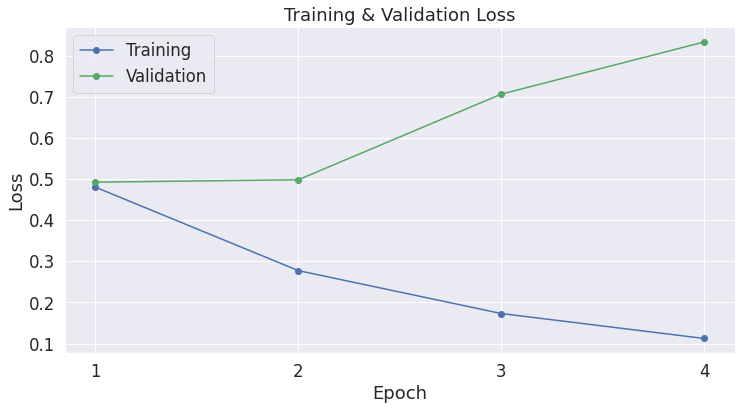

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## 5. 훈련셋에서의 성능